<a href="https://colab.research.google.com/github/itshimanshu2602/Optimal-Control-of-a-Constrained-Bilinear-Dynamic-System_Krotov/blob/main/Optimal_Control_of_a_Constrained_Bilinear_Dynamic_System_Krotov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Running CBQR Simulation ---
CBQR Iteration 0: J = 1.834055e+11
CBQR Iteration 1: J = 2.375431e+11, Change = 5.414e+10, Time: 4.23s
CBQR Iteration 2: J = 1.366531e+11, Change = 1.009e+11, Time: 6.46s
CBQR Iteration 3: J = 1.505207e+11, Change = 1.387e+10, Time: 3.36s
CBQR Iteration 4: J = 1.401373e+11, Change = 1.038e+10, Time: 2.19s
CBQR Iteration 5: J = 1.436715e+11, Change = 3.534e+09, Time: 0.72s
CBQR Iteration 6: J = 1.419411e+11, Change = 1.730e+09, Time: 0.57s
CBQR Iteration 7: J = 1.426484e+11, Change = 7.073e+08, Time: 0.58s
CBQR Iteration 8: J = 1.423434e+11, Change = 3.049e+08, Time: 0.57s
CBQR Iteration 9: J = 1.424759e+11, Change = 1.325e+08, Time: 0.61s
CBQR Iteration 10: J = 1.424102e+11, Change = 6.566e+07, Time: 0.56s
CBQR Iteration 11: J = 1.424474e+11, Change = 3.711e+07, Time: 0.59s
CBQR Iteration 12: J = 1.424301e+11, Change = 1.727e+07, Time: 0.62s
CBQR Iteration 13: J = 1.424297e+11, Change = 4.310e+05, Time: 0.59s
CBQR Iteration 14: J = 1.424371e+11, Change 

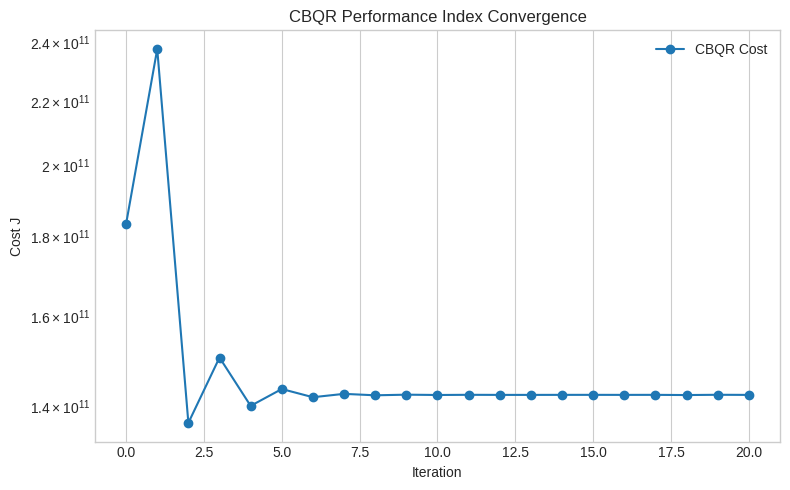

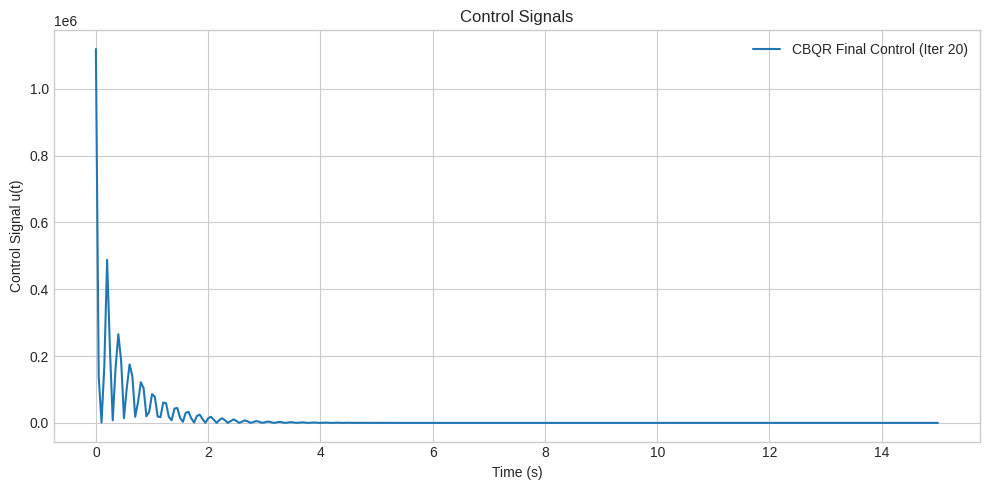

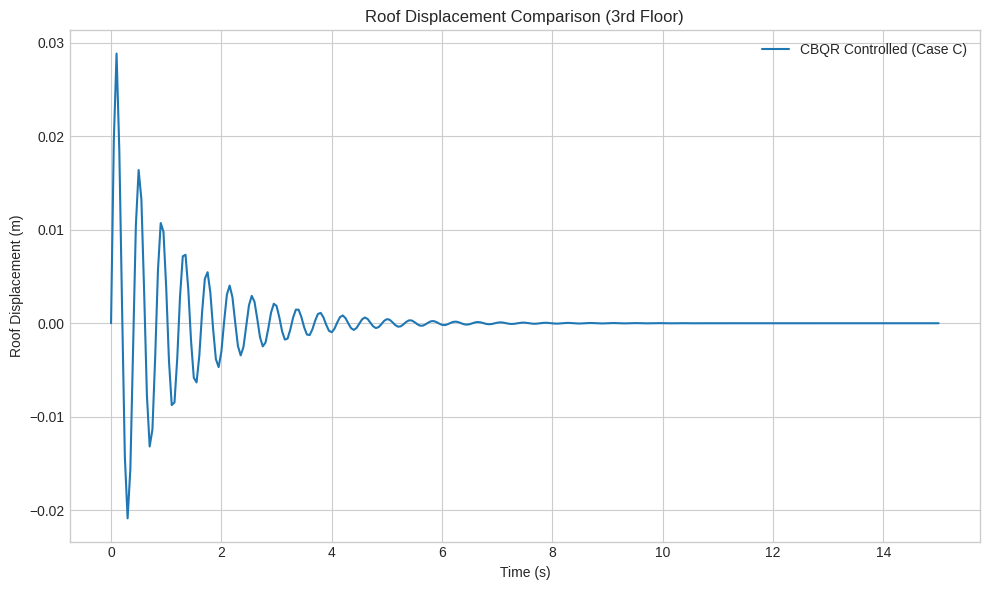

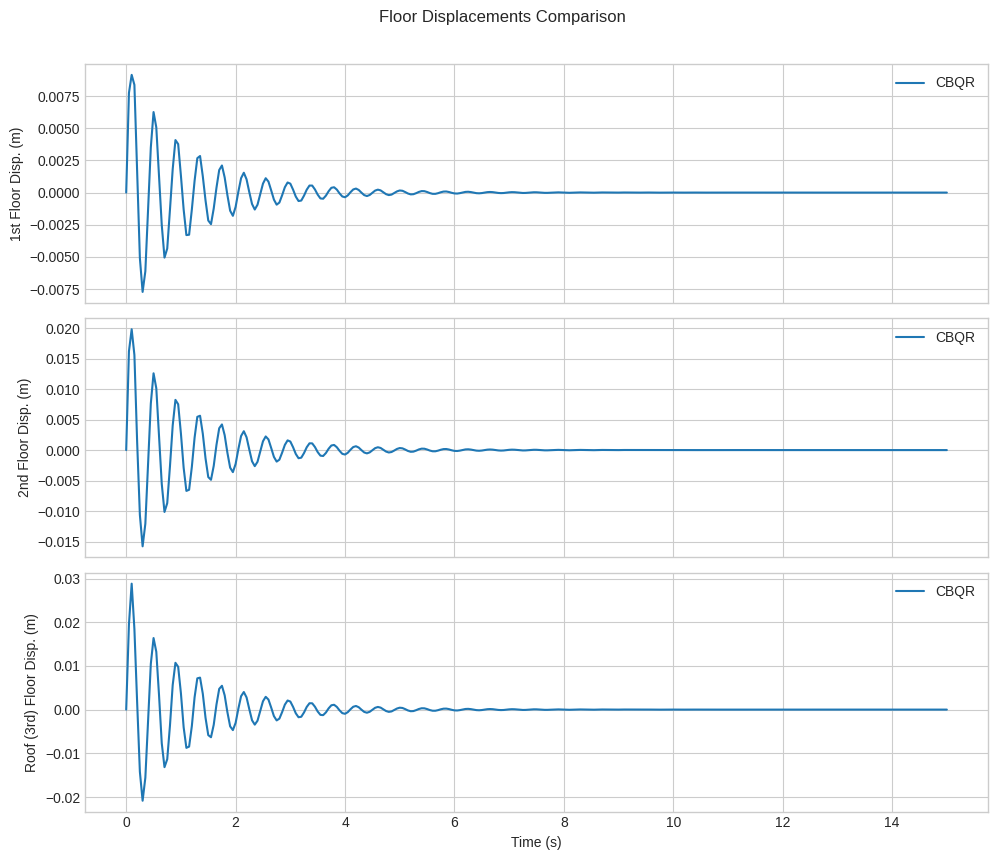

In [1]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time # To measure computation time

# --- Reuse CBQR Solver (from previous response) ---
def cbqr_solve(A, b, c, Q, r, x0, tf, num_steps=101, max_iter=50, epsilon=1e-6, verbose=True):
    """
    Solves the finite-horizon optimal control problem using the CBQR algorithm.
    (Includes minor improvements like verbosity control and r > 1e-9 check)
    """
    n = A.shape[0]
    x0 = x0.reshape(-1)
    t_eval = np.linspace(0, tf, num_steps)
    bc_matrix = b @ c

    # --- Initialization ---
    k = 0
    u_k = np.zeros(num_steps)
    x_hist = []
    u_hist = [u_k]
    P_hist = []
    J_hist = []

    def initial_state_ode(t, x): return A @ x
    sol_x0 = solve_ivp(initial_state_ode, [0, tf], x0, t_eval=t_eval, dense_output=True)
    x_k = sol_x0.y
    x_hist.append(x_k)

    def initial_adjoint_ode(t, p_flat):
        P = p_flat.reshape((n, n))
        P_dot = -P @ A - A.T @ P - Q
        return P_dot.flatten()
    P0_tf = np.zeros((n, n))
    sol_P0 = solve_ivp(initial_adjoint_ode, [tf, 0], P0_tf.flatten(), t_eval=t_eval[::-1], dense_output=True)
    P_k_sol = sol_P0
    P_hist.append(P_k_sol)

    integrand_J0 = 0.5 * (np.sum(x_k * (Q @ x_k), axis=0))
    J_k = trapezoid(integrand_J0, t_eval)
    J_hist.append(J_k)
    if verbose: print(f"CBQR Iteration {k}: J = {J_k:.6e}")

    # --- Iteration Loop ---
    converged = False
    start_time = time.time()
    for k in range(max_iter):
        iter_start_time = time.time()
        J_prev = J_k
        P_k_dense = P_k_sol.sol

        def forward_ode(t, x):
            P_current = P_k_dense(t).reshape((n, n))
            numerator = x.T @ P_current @ bc_matrix @ x
            u_hat = max(numerator / r, 0) if r > 1e-9 else (0 if numerator <= 0 else np.inf)
            x_dot = (A - u_hat * bc_matrix) @ x
            return x_dot

        sol_xk_plus_1 = solve_ivp(forward_ode, [0, tf], x0, t_eval=t_eval, dense_output=True)
        x_kp1 = sol_xk_plus_1.y

        u_kp1 = np.zeros(num_steps)
        for i, t_step in enumerate(t_eval):
            x_current = x_kp1[:, i]
            P_current = P_k_dense(t_step).reshape((n, n))
            numerator = x_current.T @ P_current @ bc_matrix @ x_current
            u_kp1[i] = max(numerator / r, 0) if r > 1e-9 else (0 if numerator <= 0 else np.inf)

        u_kp1_interp = interp1d(t_eval, u_kp1, kind='linear', fill_value="extrapolate") # Use linear for robustness

        def backward_ode(t, p_flat):
            P = p_flat.reshape((n, n))
            u_val = u_kp1_interp(t)
            A_cl = A - u_val * bc_matrix
            P_dot = -P @ A_cl - A_cl.T @ P - Q
            return P_dot.flatten()

        P_kp1_tf = np.zeros((n, n))
        sol_Pk_plus_1 = solve_ivp(backward_ode, [tf, 0], P_kp1_tf.flatten(), t_eval=t_eval[::-1], dense_output=True)

        integrand_J_kp1 = 0.5 * (np.sum(x_kp1 * (Q @ x_kp1), axis=0) + r * u_kp1**2)
        J_kp1 = trapezoid(integrand_J_kp1, t_eval)

        iter_time = time.time() - iter_start_time
        if verbose: print(f"CBQR Iteration {k+1}: J = {J_kp1:.6e}, Change = {abs(J_kp1 - J_prev):.3e}, Time: {iter_time:.2f}s")

        x_hist.append(x_kp1)
        u_hist.append(u_kp1)
        P_hist.append(sol_Pk_plus_1)
        J_hist.append(J_kp1)

        # Update for next iteration (only need P_k_sol and J_k)
        P_k_sol = sol_Pk_plus_1
        J_k = J_kp1

        if abs(J_kp1 - J_prev) < epsilon:
            if verbose: print(f"\nCBQR Converged after {k+1} iterations.")
            converged = True
            break

    total_time = time.time() - start_time
   # if not converged and verbose:
  #      print(f"\nCBQR Did not converge within {max_iter} iterations.")
  #  if verbose: print(f"CBQR Total iteration time: {total_time:.2f}s")

    results = {
        't': t_eval, 'x_hist': x_hist, 'u_hist': u_hist,
        'P_hist': P_hist, 'J_hist': J_hist, 'converged': converged,
        'final_k': k + 1 if converged else max_iter, 'comp_time': total_time,
        'type': 'CBQR'
    }
    return results



# --- Main Execution ---
if __name__ == "__main__":

    # 1. Define System Parameters from Image
    M = np.array([[25.2, 0.246, -0.0591],
                  [0.246, 25.2, 0.168],
                  [-0.0591, 0.168, 25.5]]) * 1e3

    Cd = np.array([[160., -68.6, 6.75],
                   [-68.6, 152., -60.3],
                   [6.75, -60.3, 82.7]]) * 1e3

    K = np.array([[80.2, -42.1, 4.17],
                  [-42.1, 75.5, -37.],
                  [4.17, -37., 32.6]]) * 1e6

    phi = np.array([[0.982],
                    [0.0092],
                    [-0.000875]])

    # Construct 6x6 Q matrix
    Q_3x3 = np.array([[6, -3, 0],
                      [-3, 6, -3],
                      [0, -3, 3]])
    Q = np.zeros((6, 6))
    Q[0:3, 0:3] = Q_3x3
    Q *= 1e15 # Apply scaling factor

    r = 1.0 # Control cost scalar
    R = np.array([[r]]) # Control cost matrix for LQR (since u is scalar)

    # Initial state: [q1, q2, q3, dq1, dq2, dq3]
    x0 = np.array([0, 0, 0, 0.4, 0.4, 0.4])

    # Simulation parameters
    tf = 15.0 # Final time (seconds) - adjust as needed
    num_steps = 301 # Number of time steps

    # 2. Calculate State-Space Matrices
    M_inv = np.linalg.inv(M)
    A_sys = np.block([
        [np.zeros((3, 3)), np.eye(3)],
        [-M_inv @ K, -M_inv @ Cd]
    ])

    # CBQR matrices
    b_cbqr = np.vstack([np.zeros((3, 1)), M_inv @ phi])
    c_cbqr = np.hstack([np.zeros((1, 3)), phi.T])

    # LQR matrix (B is same as b_cbqr here)


    # 3. Run Simulations


    print("\n--- Running CBQR Simulation ---")
    results_cbqr = cbqr_solve(A_sys, b_cbqr, c_cbqr, Q, r, x0, tf, num_steps, max_iter=20, epsilon=1e-9) # Use lower tolerance

    # 4. Plot Results
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot 1: Performance Index (Cost J) Convergence for CBQR
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(results_cbqr['J_hist'])), results_cbqr['J_hist'], 'o-', label='CBQR Cost')
    plt.xlabel('Iteration')
    plt.ylabel('Cost J')
    plt.title('CBQR Performance Index Convergence')
    plt.yscale('log') # Often useful to see convergence better
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: CBQR Control Signal u(t)
    plt.figure(figsize=(10, 5))
    plt.plot(results_cbqr['t'], results_cbqr['u_hist'][-1], label=f'CBQR Final Control (Iter {results_cbqr["final_k"]})')

    plt.xlabel('Time (s)')
    plt.ylabel('Control Signal u(t)')
    plt.title('Control Signals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Roof Displacement (x_3, which is index 2)
    plt.figure(figsize=(10, 6))
    plt.plot(results_cbqr['t'], results_cbqr['x_hist'][-1][2, :], '-', label='CBQR Controlled (Case C)')
    plt.xlabel('Time (s)')
    plt.ylabel('Roof Displacement (m)') # Assuming units
    plt.title('Roof Displacement Comparison (3rd Floor)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Plot all displacements
    fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
    floors = ['1st', '2nd', 'Roof (3rd)']
    for i in range(3):
      axs[i].plot(results_cbqr['t'], results_cbqr['x_hist'][-1][i, :], '-', label='CBQR')
      axs[i].set_ylabel(f'{floors[i]} Floor Disp. (m)')
      axs[i].grid(True)
      axs[i].legend()
    axs[2].set_xlabel('Time (s)')
    fig.suptitle('Floor Displacements Comparison')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for suptitle
    plt.show()

--- Running Uncontrolled Simulation ---
Uncontrolled Final Cost J = 1.834055e+11

--- Running LQR Simulation ---
LQR DRE solve time: 0.21s
LQR Forward simulation time: 0.19s
LQR Final Cost J = 1.030549e+13

--- Running CBQR Simulation ---
CBQR Iteration 0: J = 1.834055e+11
CBQR Iteration 1: J = 2.375431e+11, Change = 5.414e+10, Time: 0.59s
CBQR Iteration 2: J = 1.366531e+11, Change = 1.009e+11, Time: 0.58s
CBQR Iteration 3: J = 1.505207e+11, Change = 1.387e+10, Time: 0.60s
CBQR Iteration 4: J = 1.401373e+11, Change = 1.038e+10, Time: 0.61s
CBQR Iteration 5: J = 1.436715e+11, Change = 3.534e+09, Time: 0.58s
CBQR Iteration 6: J = 1.419411e+11, Change = 1.730e+09, Time: 0.57s
CBQR Iteration 7: J = 1.426484e+11, Change = 7.073e+08, Time: 0.60s
CBQR Iteration 8: J = 1.423434e+11, Change = 3.049e+08, Time: 0.59s
CBQR Iteration 9: J = 1.424759e+11, Change = 1.325e+08, Time: 0.60s
CBQR Iteration 10: J = 1.424102e+11, Change = 6.566e+07, Time: 0.73s
CBQR Iteration 11: J = 1.424474e+11, Change =

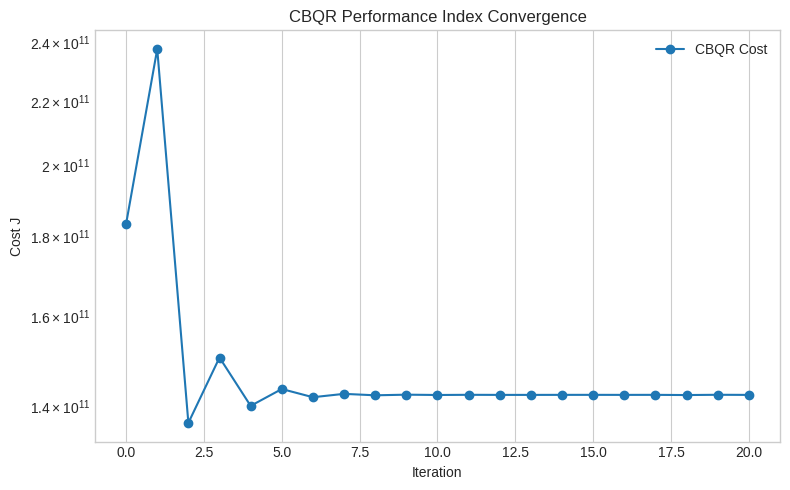

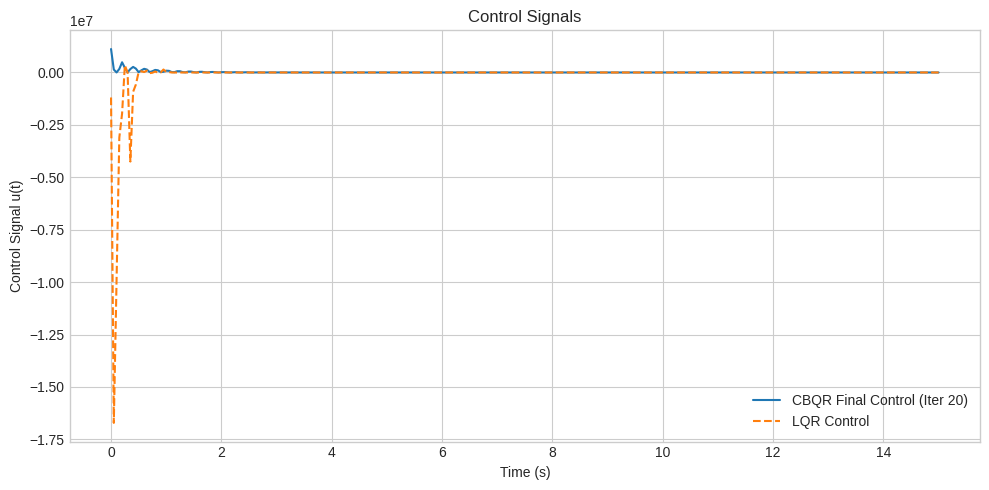

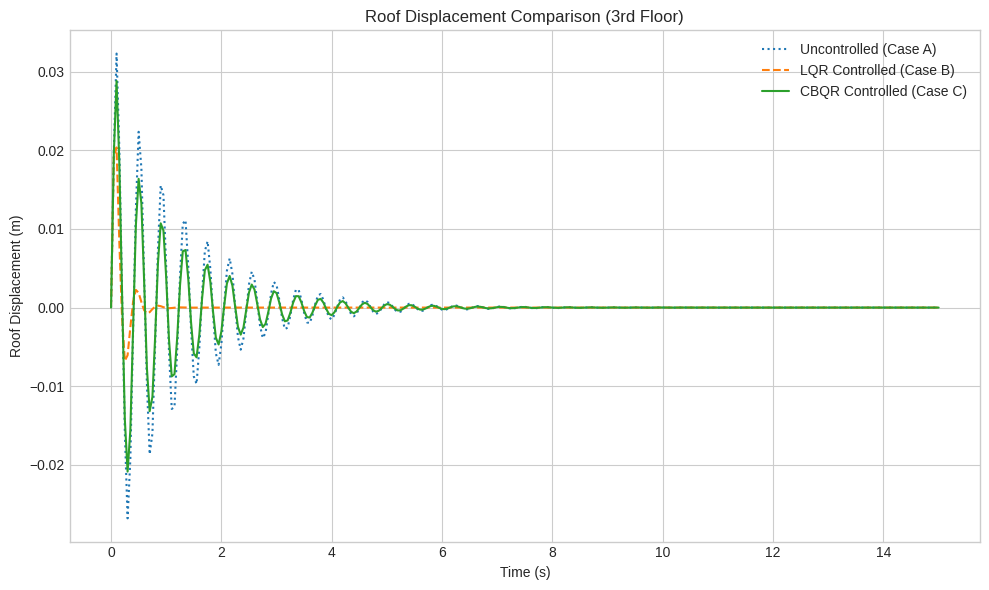

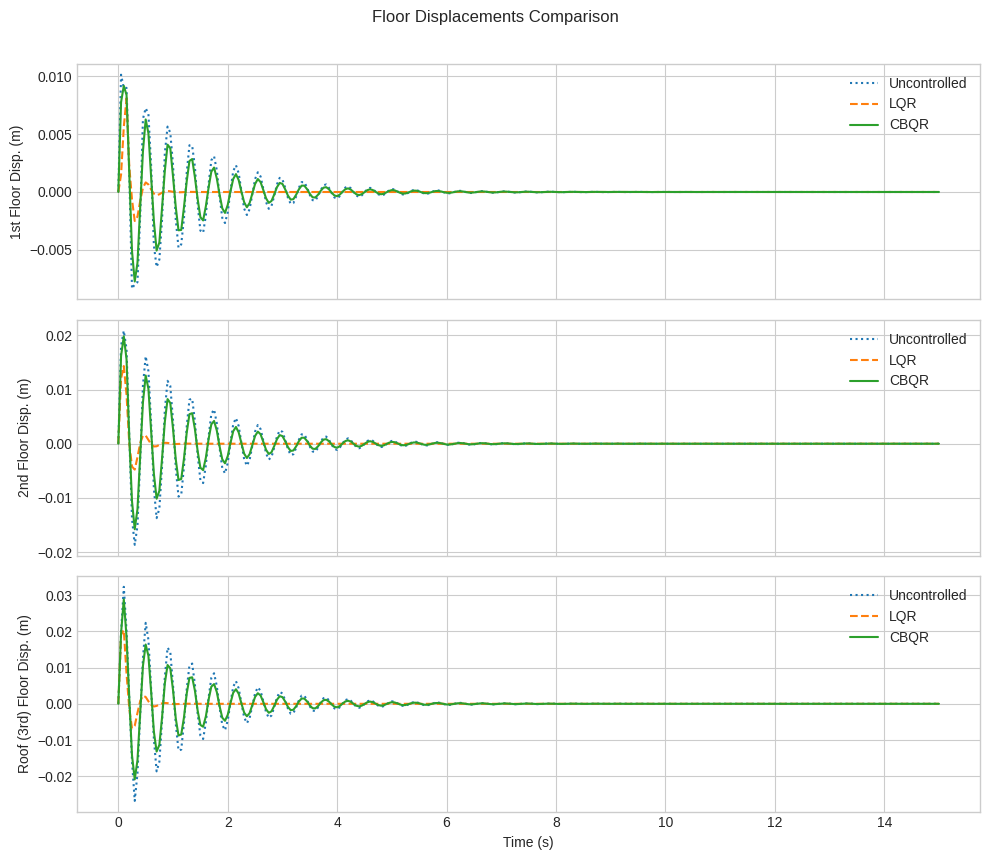

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time # To measure computation time

# --- Reuse CBQR Solver (from previous response) ---
def cbqr_solve(A, b, c, Q, r, x0, tf, num_steps=101, max_iter=50, epsilon=1e-6, verbose=True):
    """
    Solves the finite-horizon optimal control problem using the CBQR algorithm.
    (Includes minor improvements like verbosity control and r > 1e-9 check)
    """
    n = A.shape[0]
    x0 = x0.reshape(-1)
    t_eval = np.linspace(0, tf, num_steps)
    bc_matrix = b @ c

    # --- Initialization ---
    k = 0
    u_k = np.zeros(num_steps)
    x_hist = []
    u_hist = [u_k]
    P_hist = []
    J_hist = []

    def initial_state_ode(t, x): return A @ x
    sol_x0 = solve_ivp(initial_state_ode, [0, tf], x0, t_eval=t_eval, dense_output=True)
    x_k = sol_x0.y
    x_hist.append(x_k)

    def initial_adjoint_ode(t, p_flat):
        P = p_flat.reshape((n, n))
        P_dot = -P @ A - A.T @ P - Q
        return P_dot.flatten()
    P0_tf = np.zeros((n, n))
    sol_P0 = solve_ivp(initial_adjoint_ode, [tf, 0], P0_tf.flatten(), t_eval=t_eval[::-1], dense_output=True)
    P_k_sol = sol_P0
    P_hist.append(P_k_sol)

    integrand_J0 = 0.5 * (np.sum(x_k * (Q @ x_k), axis=0))
    J_k = trapezoid(integrand_J0, t_eval)
    J_hist.append(J_k)
    if verbose: print(f"CBQR Iteration {k}: J = {J_k:.6e}")

    # --- Iteration Loop ---
    converged = False
    start_time = time.time()
    for k in range(max_iter):
        iter_start_time = time.time()
        J_prev = J_k
        P_k_dense = P_k_sol.sol

        def forward_ode(t, x):
            P_current = P_k_dense(t).reshape((n, n))
            numerator = x.T @ P_current @ bc_matrix @ x
            u_hat = max(numerator / r, 0) if r > 1e-9 else (0 if numerator <= 0 else np.inf)
            x_dot = (A - u_hat * bc_matrix) @ x
            return x_dot

        sol_xk_plus_1 = solve_ivp(forward_ode, [0, tf], x0, t_eval=t_eval, dense_output=True)
        x_kp1 = sol_xk_plus_1.y

        u_kp1 = np.zeros(num_steps)
        for i, t_step in enumerate(t_eval):
            x_current = x_kp1[:, i]
            P_current = P_k_dense(t_step).reshape((n, n))
            numerator = x_current.T @ P_current @ bc_matrix @ x_current
            u_kp1[i] = max(numerator / r, 0) if r > 1e-9 else (0 if numerator <= 0 else np.inf)

        u_kp1_interp = interp1d(t_eval, u_kp1, kind='linear', fill_value="extrapolate") # Use linear for robustness

        def backward_ode(t, p_flat):
            P = p_flat.reshape((n, n))
            u_val = u_kp1_interp(t)
            A_cl = A - u_val * bc_matrix
            P_dot = -P @ A_cl - A_cl.T @ P - Q
            return P_dot.flatten()

        P_kp1_tf = np.zeros((n, n))
        sol_Pk_plus_1 = solve_ivp(backward_ode, [tf, 0], P_kp1_tf.flatten(), t_eval=t_eval[::-1], dense_output=True)

        integrand_J_kp1 = 0.5 * (np.sum(x_kp1 * (Q @ x_kp1), axis=0) + r * u_kp1**2)
        J_kp1 = trapezoid(integrand_J_kp1, t_eval)

        iter_time = time.time() - iter_start_time
        if verbose: print(f"CBQR Iteration {k+1}: J = {J_kp1:.6e}, Change = {abs(J_kp1 - J_prev):.3e}, Time: {iter_time:.2f}s")

        x_hist.append(x_kp1)
        u_hist.append(u_kp1)
        P_hist.append(sol_Pk_plus_1)
        J_hist.append(J_kp1)

        # Update for next iteration (only need P_k_sol and J_k)
        P_k_sol = sol_Pk_plus_1
        J_k = J_kp1

        if abs(J_kp1 - J_prev) < epsilon:
            if verbose: print(f"\nCBQR Converged after {k+1} iterations.")
            converged = True
            break

    total_time = time.time() - start_time
    if not converged and verbose:
        print(f"\nCBQR Did not converge within {max_iter} iterations.")
    if verbose: print(f"CBQR Total iteration time: {total_time:.2f}s")

    results = {
        't': t_eval, 'x_hist': x_hist, 'u_hist': u_hist,
        'P_hist': P_hist, 'J_hist': J_hist, 'converged': converged,
        'final_k': k + 1 if converged else max_iter, 'comp_time': total_time,
        'type': 'CBQR'
    }
    return results

# --- LQR Solver (Finite Horizon using DRE) ---
def lqr_solve(A, B, Q, R, x0, tf, num_steps=101, verbose=True):
    """Solves the finite-horizon LQR problem."""
    n = A.shape[0]
    m = B.shape[1] # Number of inputs
    x0 = x0.reshape(-1)
    t_eval = np.linspace(0, tf, num_steps)
    Rinv = np.linalg.inv(R) if R.ndim == 2 else 1.0 / R

    # --- Backward Pass: Solve Differential Riccati Equation (DRE) ---
    # P_dot = -P*A - A^T*P + P*B*Rinv*B^T*P - Q
    def backward_riccati_ode(t, p_flat):
        P = p_flat.reshape((n, n))
        PBRinvBT = P @ B @ Rinv @ B.T
        P_dot = -P @ A - A.T @ P + PBRinvBT @ P - Q
        return P_dot.flatten()

    P_tf = np.zeros((n, n)) # Final condition P(tf) = 0
    start_time_dre = time.time()
    sol_P_lqr = solve_ivp(backward_riccati_ode, [tf, 0], P_tf.flatten(), t_eval=t_eval[::-1], dense_output=True)
    time_dre = time.time() - start_time_dre
    if verbose: print(f"LQR DRE solve time: {time_dre:.2f}s")
    P_lqr_dense = sol_P_lqr.sol

    # --- Forward Pass: Simulate Controlled System ---
    # x_dot = (A - B*Rinv*B^T*P(t))*x
    def forward_lqr_ode(t, x):
        P_current = P_lqr_dense(t).reshape((n, n))
        K_lqr = Rinv @ B.T @ P_current # Optimal gain K(t) = Rinv*B^T*P(t)
        x_dot = (A - B @ K_lqr) @ x
        return x_dot

    start_time_fwd = time.time()
    sol_x_lqr = solve_ivp(forward_lqr_ode, [0, tf], x0, t_eval=t_eval, dense_output=True)
    time_fwd = time.time() - start_time_fwd
    if verbose: print(f"LQR Forward simulation time: {time_fwd:.2f}s")
    x_lqr = sol_x_lqr.y

    # --- Calculate Control Signal and Cost ---
    u_lqr = np.zeros((m, num_steps))
    P_vals = np.array([P_lqr_dense(t).reshape((n,n)) for t in t_eval]).transpose(2,0,1) # Shape (n, n, num_steps)

    # Calculate K(t) efficiently
    # K = Rinv @ B.T @ P(t) -> shape (m, n, num_steps)
    K_lqr_t = Rinv @ B.T @ P_vals.reshape(n, n * num_steps) # K = Rinv B^T P
    K_lqr_t = K_lqr_t.reshape(m, n, num_steps) # Reshape K

    # Calculate u(t) = -K(t)x(t)
    for i in range(num_steps):
      u_lqr[:, i] = -K_lqr_t[:, :, i] @ x_lqr[:, i]

    # Calculate cost J = 0.5 * integral(x^T Q x + u^T R u) dt
    # Note: Original CBQR paper uses 1/2 factor, standard LQR often doesn't
    # We'll use 1/2 for consistency with CBQR J plot
    xTQx = np.sum(x_lqr * (Q @ x_lqr), axis=0)
    uTRu = np.sum(u_lqr * (R @ u_lqr), axis=0) if R.ndim==2 else R * np.sum(u_lqr**2, axis=0)
    integrand_J_lqr = 0.5 * (xTQx + uTRu)
    J_lqr = trapezoid(integrand_J_lqr, t_eval)

    if verbose: print(f"LQR Final Cost J = {J_lqr:.6e}")

    results = {
        't': t_eval, 'x': x_lqr, 'u': u_lqr.squeeze(), # Squeeze if m=1
        'P_sol': sol_P_lqr, 'J': J_lqr,
        'comp_time': time_dre + time_fwd, 'type': 'LQR'
    }
    return results

# --- Uncontrolled System Solver ---
def uncontrolled_solve(A, Q, x0, tf, num_steps=101):
    """Simulates the uncontrolled system x_dot = Ax."""
    n = A.shape[0]
    x0 = x0.reshape(-1)
    t_eval = np.linspace(0, tf, num_steps)

    def forward_uncontrolled_ode(t, x):
        return A @ x

    sol_x_unc = solve_ivp(forward_uncontrolled_ode, [0, tf], x0, t_eval=t_eval)
    x_unc = sol_x_unc.y
    u_unc = np.zeros(num_steps) # No control

    # Calculate cost J = 0.5 * integral(x^T Q x) dt (R term is zero)
    xTQx = np.sum(x_unc * (Q @ x_unc), axis=0)
    integrand_J_unc = 0.5 * xTQx
    J_unc = trapezoid(integrand_J_unc, t_eval)
    print(f"Uncontrolled Final Cost J = {J_unc:.6e}")


    results = {
        't': t_eval, 'x': x_unc, 'u': u_unc, 'J': J_unc, 'type': 'Uncontrolled'
    }
    return results


# --- Main Execution ---
if __name__ == "__main__":

    # 1. Define System Parameters from Image
    M = np.array([[25.2, 0.246, -0.0591],
                  [0.246, 25.2, 0.168],
                  [-0.0591, 0.168, 25.5]]) * 1e3

    Cd = np.array([[160., -68.6, 6.75],
                   [-68.6, 152., -60.3],
                   [6.75, -60.3, 82.7]]) * 1e3

    K = np.array([[80.2, -42.1, 4.17],
                  [-42.1, 75.5, -37.],
                  [4.17, -37., 32.6]]) * 1e6

    phi = np.array([[0.982],
                    [0.0092],
                    [-0.000875]])

    # Construct 6x6 Q matrix
    Q_3x3 = np.array([[6, -3, 0],
                      [-3, 6, -3],
                      [0, -3, 3]])
    Q = np.zeros((6, 6))
    Q[0:3, 0:3] = Q_3x3
    Q *= 1e15 # Apply scaling factor

    r = 1.0 # Control cost scalar
    R = np.array([[r]]) # Control cost matrix for LQR (since u is scalar)

    # Initial state: [q1, q2, q3, dq1, dq2, dq3]
    x0 = np.array([0, 0, 0, 0.4, 0.4, 0.4])

    # Simulation parameters
    tf = 15.0 # Final time (seconds) - adjust as needed
    num_steps = 301 # Number of time steps

    # 2. Calculate State-Space Matrices
    M_inv = np.linalg.inv(M)
    A_sys = np.block([
        [np.zeros((3, 3)), np.eye(3)],
        [-M_inv @ K, -M_inv @ Cd]
    ])

    # CBQR matrices
    b_cbqr = np.vstack([np.zeros((3, 1)), M_inv @ phi])
    c_cbqr = np.hstack([np.zeros((1, 3)), phi.T])

    # LQR matrix (B is same as b_cbqr here)
    B_lqr = b_cbqr

    # 3. Run Simulations
    print("--- Running Uncontrolled Simulation ---")
    results_unc = uncontrolled_solve(A_sys, Q, x0, tf, num_steps)

    print("\n--- Running LQR Simulation ---")
    results_lqr = lqr_solve(A_sys, B_lqr, Q, R, x0, tf, num_steps)

    print("\n--- Running CBQR Simulation ---")
    results_cbqr = cbqr_solve(A_sys, b_cbqr, c_cbqr, Q, r, x0, tf, num_steps, max_iter=20, epsilon=1e-9) # Use lower tolerance

    # 4. Plot Results
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot 1: Performance Index (Cost J) Convergence for CBQR
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(results_cbqr['J_hist'])), results_cbqr['J_hist'], 'o-', label='CBQR Cost')
    plt.xlabel('Iteration')
    plt.ylabel('Cost J')
    plt.title('CBQR Performance Index Convergence')
    plt.yscale('log') # Often useful to see convergence better
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: CBQR Control Signal u(t)
    plt.figure(figsize=(10, 5))
    plt.plot(results_cbqr['t'], results_cbqr['u_hist'][-1], label=f'CBQR Final Control (Iter {results_cbqr["final_k"]})')
    plt.plot(results_lqr['t'], results_lqr['u'], '--', label='LQR Control')
    plt.xlabel('Time (s)')
    plt.ylabel('Control Signal u(t)')
    plt.title('Control Signals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Roof Displacement (x_3, which is index 2)
    plt.figure(figsize=(10, 6))
    plt.plot(results_unc['t'], results_unc['x'][2, :], ':', label='Uncontrolled (Case A)')
    plt.plot(results_lqr['t'], results_lqr['x'][2, :], '--', label='LQR Controlled (Case B)')
    plt.plot(results_cbqr['t'], results_cbqr['x_hist'][-1][2, :], '-', label='CBQR Controlled (Case C)')
    plt.xlabel('Time (s)')
    plt.ylabel('Roof Displacement (m)') # Assuming units
    plt.title('Roof Displacement Comparison (3rd Floor)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Plot all displacements
    fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
    floors = ['1st', '2nd', 'Roof (3rd)']
    for i in range(3):
      axs[i].plot(results_unc['t'], results_unc['x'][i, :], ':', label='Uncontrolled')
      axs[i].plot(results_lqr['t'], results_lqr['x'][i, :], '--', label='LQR')
      axs[i].plot(results_cbqr['t'], results_cbqr['x_hist'][-1][i, :], '-', label='CBQR')
      axs[i].set_ylabel(f'{floors[i]} Floor Disp. (m)')
      axs[i].grid(True)
      axs[i].legend()
    axs[2].set_xlabel('Time (s)')
    fig.suptitle('Floor Displacements Comparison')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for suptitle
    plt.show()